In [1]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00


In [25]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt

class EmbeddingVisualizer:
    def __init__(self, model_name="BAAI/bge-large-en-v1.5"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def track_token_embedding(self, text: str, token_position: int = 0):
        # Tokenize input
        inputs = self.tokenizer(text, return_tensors='pt', padding=True)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        # Get embeddings from all layers
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)

        # Collect the specified token's embedding from each layer
        token_embeddings = []

        for layer_idx, layer_output in enumerate(outputs.hidden_states):
            # Extract the embedding for the specified token
            # Shape of layer_output is [1, sequence_length, 1024]
            # We take [0] to remove batch dimension, [token_position] to get specific token
            token_embedding = layer_output[0, token_position].numpy()
            token_embeddings.append(token_embedding)

        token_embeddings = np.array(token_embeddings)

        print(f"\nTracking embedding changes for token: '{tokens[token_position]}'")
        print(f"Number of layers: {len(token_embeddings)}")
        print(f"Embedding dimension: {token_embeddings.shape[1]}")

        # Calculate statistics
        means = np.mean(token_embeddings, axis=1)
        stds = np.std(token_embeddings, axis=1)

        # Plot embedding changes
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Plot mean values across layers
        ax1.plot(means, label='Mean value')
        ax1.fill_between(range(len(means)), means - stds, means + stds, alpha=0.3, label='±1 std')
        ax1.set_title('Mean Embedding Value Across Layers')
        ax1.set_xlabel('Layer')
        ax1.set_ylabel('Mean Value')
        ax1.legend()
        ax1.grid(True)

        # Plot first 5 dimensions across layers
        for i in range(5):
            ax2.plot(token_embeddings[:, i], label=f'Dim {i}')
        ax2.set_title('First 5 Embedding Dimensions Across Layers')
        ax2.set_xlabel('Layer')
        ax2.set_ylabel('Value')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        return {
            'embeddings': token_embeddings,
            'means': means,
            'stds': stds,
            'token': tokens[token_position]
        }

    def track_sentence_embeddings(self, text):
        inputs = self.tokenizer(text, return_tensors='pt')

        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)

        layer_embeddings = []
        for layer_output in outputs.hidden_states:
            # Layer norm
            normalized = self.model.encoder.layer[0].attention.output.LayerNorm(layer_output)
            # Mean pool
            sentence_embedding = torch.mean(normalized, dim=1)  # [1, 1024]
            # L2 normalize
            sentence_embedding = torch.nn.functional.normalize(sentence_embedding, p=2, dim=1)
            layer_embeddings.append(sentence_embedding)

        return np.array(layer_embeddings)


In [3]:
visualizer = EmbeddingVisualizer()
text = "The old lighthouse keeper whispered secrets to the stormy sea, hoping the waves would carry his words to distant shores."

embeddings = visualizer.track_sentence_embeddings(text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [6]:
import torch
import numpy as np

def detachLayers(embeddings):
    return [layer.detach().numpy() for layer in embeddings]

embeddings = detachLayers(embeddings)

In [7]:
import numpy as np
import torch
from sklearn.decomposition import PCA

def perform_pca(embeddings_list, n_components=2):
    # Concatenate embeddings into a single array
    all_embeddings = np.concatenate(embeddings_list, axis=0)

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(all_embeddings)

    return reduced_embeddings

reduced_embeddings = perform_pca(embeddings)

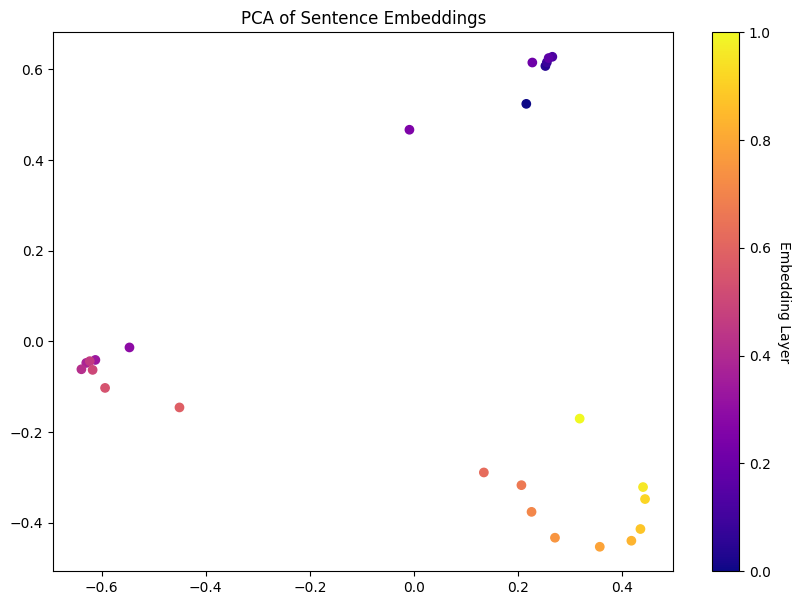

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_embeddings(embeddings, title="PCA of Sentence Embeddings"):
    plt.figure(figsize=(10, 7))  # Made figure slightly larger to accommodate colorbar

    # Create array of indices normalized between 0 and 1
    indices = np.linspace(0, 1, len(embeddings))

    # Use 'plasma' colormap for better visibility - transitions through purple, orange, yellow
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                        c=indices,
                        cmap='plasma')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Embedding Layer', rotation=270, labelpad=15)

    plt.title(title)
    plt.show()

plot_embeddings(reduced_embeddings)

In [9]:
import umap

def umap_embeddings(embeddings, n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(random_state=42, n_neighbors=n_neighbors, min_dist=min_dist)
    embedding_2d = reducer.fit_transform(reduced_embeddings)
    return embedding_2d

plot_embeddings(umap_embeddings(embeddings), title='UMAP')

In [31]:
sentences = [
   "The quantum physicist's cat danced between probability waves, simultaneously alive and dead in the moonlight.",
   "Beneath the ancient redwood trees, memories of a thousand winters sleep in rings of silent wood.",
   "The robot learned to paint sunsets by analyzing millions of human tears.",
#    "In the bustling Tokyo market, an old woman's origami butterflies caught the wind and became real.",
#    "Through the telescope, the child watched stars being born while her grandmother told stories of stars dying."
]
embeddings = [visualizer.track_sentence_embeddings(i) for i in sentences]
embeddings = [detachLayers(i) for i in embeddings]
print(embeddings[0][0][0])

# embeddings = [perform_pca(i) for i in embeddings]
# for i in embeddings:
#     plot_embeddings(i, title='PCA')
#     plot_embeddings(umap_embeddings(i), title='UMAP')


[ 0.004725    0.00268267  0.01829812 ... -0.01321516  0.01436856
  0.00731281]


In [36]:
import torch
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from tqdm import tqdm

class EmbeddingSensitivityAnalyzer:
    def __init__(self, model, tokenizer, epsilon=0.1, n_points=10):
        self.model = model
        self.tokenizer = tokenizer
        self.epsilon = epsilon
        self.n_points = n_points

    def compute_embedding(self, text: str, layer_idx: int = -1) -> torch.Tensor:
        """Compute normalized embedding for a given text at specified layer."""
        inputs = self.tokenizer(text, return_tensors='pt')

        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)

        layer_output = outputs.hidden_states[layer_idx]
        normalized = self.model.encoder.layer[0].attention.output.LayerNorm(layer_output)
        sentence_embedding = torch.mean(normalized, dim=1)
        return torch.nn.functional.normalize(sentence_embedding, p=2, dim=1)

    def compute_directional_sensitivity(self,
                                     base_text: str,
                                     perturbed_text: str,
                                     layer_idx: int = -1) -> float:
        """Compute cosine distance between base and perturbed embeddings."""
        base_embedding = self.compute_embedding(base_text, layer_idx)
        perturbed_embedding = self.compute_embedding(perturbed_text, layer_idx)

        cosine_sim = torch.nn.functional.cosine_similarity(base_embedding,
                                                         perturbed_embedding)
        return float(1 - cosine_sim)

    def analyze_token_sensitivity(self,
                                text: str,
                                layer_indices: List[int] = None) -> Dict:
        """Analyze sensitivity to token-level changes."""
        if layer_indices is None:
            layer_indices = [-1]  # Default to last layer

        tokens = self.tokenizer.tokenize(text)
        results = {layer_idx: [] for layer_idx in layer_indices}

        for layer_idx in layer_indices:
            sensitivities = []
            for i in range(len(tokens)):
                # Create perturbed text by removing token
                perturbed_tokens = tokens.copy()
                del perturbed_tokens[i]
                perturbed_text = self.tokenizer.convert_tokens_to_string(perturbed_tokens)

                # Compute sensitivity
                sensitivity = self.compute_directional_sensitivity(text,
                                                                perturbed_text,
                                                                layer_idx)
                sensitivities.append((tokens[i], sensitivity))

            # Sort by sensitivity
            results[layer_idx] = sorted(sensitivities,
                                      key=lambda x: x[1],
                                      reverse=True)

        return results

    def plot_token_sensitivity(self,
                             results: Dict,
                             top_k: int = 10,
                             layer_idx: int = -1):
        """Plot token sensitivity analysis results."""
        tokens, sensitivities = zip(*results[layer_idx][:top_k])

        plt.figure(figsize=(12, 6))
        plt.bar(range(len(tokens)), sensitivities)
        plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
        plt.xlabel('Tokens')
        plt.ylabel('Directional Sensitivity')
        plt.title(f'Top {top_k} Most Sensitive Tokens (Layer {layer_idx})')
        plt.tight_layout()
        return plt

    def analyze_neighborhood(self,
                           text: str,
                           target_token: str,
                           replacements: List[str],
                           layer_indices: List[int] = None) -> Dict:
        """Analyze embedding sensitivity to token replacements."""
        if layer_indices is None:
            layer_indices = [-1]

        results = {layer_idx: [] for layer_idx in layer_indices}
        tokens = self.tokenizer.tokenize(text)

        # Find target token indices
        target_indices = [i for i, token in enumerate(tokens)
                         if token == target_token]

        for layer_idx in layer_indices:
            for replacement in replacements:
                for idx in target_indices:
                    # Create perturbed text
                    perturbed_tokens = tokens.copy()
                    perturbed_tokens[idx] = replacement
                    perturbed_text = self.tokenizer.convert_tokens_to_string(
                        perturbed_tokens)

                    # Compute sensitivity
                    sensitivity = self.compute_directional_sensitivity(
                        text, perturbed_text, layer_idx)
                    results[layer_idx].append((replacement, sensitivity))

        return results

# Example usage
def analyze_text_sensitivity(text: str,
                           layer_indices: List[int] = None):
    """Convenience function to run a complete sensitivity analysis."""
    model_name = "BAAI/bge-large-en-v1.5"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    analyzer = EmbeddingSensitivityAnalyzer(model, tokenizer)

    # Token sensitivity analysis
    token_results = analyzer.analyze_token_sensitivity(text, layer_indices)

    # Print results
    for layer_idx, sensitivities in token_results.items():
        print(f"\nLayer {layer_idx} - Top 5 most sensitive tokens:")
        for token, sensitivity in sensitivities[:5]:
            print(f"Token: {token:15} Sensitivity: {sensitivity:.4f}")

    # Plot results for the last layer
    analyzer.plot_token_sensitivity(token_results)

    return token_results


Layer -2 - Top 5 most sensitive tokens:
Token: day             Sensitivity: 0.0857
Token: how             Sensitivity: 0.0710
Token: hello           Sensitivity: 0.0444
Token: world           Sensitivity: 0.0256
Token: this            Sensitivity: 0.0206

Layer -1 - Top 5 most sensitive tokens:
Token: day             Sensitivity: 0.0997
Token: how             Sensitivity: 0.0708
Token: hello           Sensitivity: 0.0577
Token: world           Sensitivity: 0.0310
Token: fine            Sensitivity: 0.0262


{-2: [('day', 0.08573436737060547),
  ('how', 0.0709870457649231),
  ('hello', 0.04443562030792236),
  ('world', 0.025629520416259766),
  ('this', 0.020553112030029297),
  ('you', 0.018869757652282715),
  ('fine', 0.015749692916870117),
  ('on', 0.010163307189941406),
  ('are', 0.008005619049072266),
  (',', 0.004596412181854248)],
 -1: [('day', 0.0997280478477478),
  ('how', 0.07083594799041748),
  ('hello', 0.057697832584381104),
  ('world', 0.03098905086517334),
  ('fine', 0.026218056678771973),
  ('this', 0.019675135612487793),
  ('you', 0.01836073398590088),
  ('on', 0.010419130325317383),
  ('are', 0.009112358093261719),
  (',', 0.004770636558532715)]}

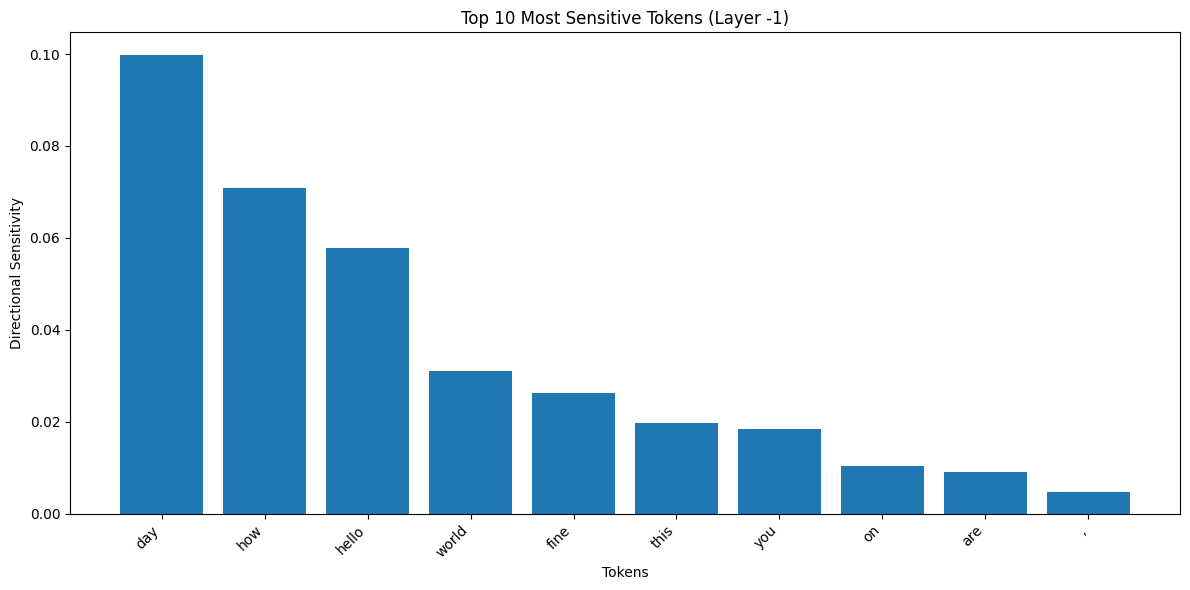

In [38]:
'''
taking text and for each token, removing one
taking the original text and newly tokenless text, compute the embeddings for both up to the specified layer
then cosine similarity of tokenless embedding and original embedding
'''

analyze_text_sensitivity('hello world, how are you on this fine day', layer_indices=[-2, -1])